# 2025-09-24 QR Factorization

* Gram-Schmidt process

* QR factorization

* Stability and ill-conditioning

* Intro to performance modeling

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

## Gram-Schmidt orthogonalization

Suppose we're given some vectors and want to find an  orthogonal basis for their span.

$$ A = \begin{split} \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} \end{split} = Q R$$

## A naive Gram-Schmidt algorithm

In [2]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_naive(A)
    m, n = size(A)
    Q = zeros(m, n) # Orthonormal basis
    R = zeros(n, n) # Upper triangular
    for j in 1:n
        v = A[:, j] # current column to normalize
        for k in 1:j-1
            # We do a projection against the previous
            #  columns of Q. Why?
            r = Q[:, k]' * v 
            v -= Q[:, k] * r
            R[k, j] = r # What is this factor?
        end
        # normalize and store our final v
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    Q, R
end

gram_schmidt_naive (generic function with 1 method)

## What do orthogonal polynomials look like

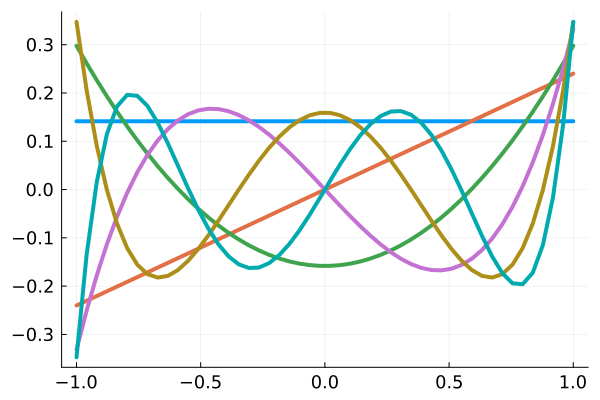

In [3]:
# Let's look at 6 orthonormal polynomials
x = LinRange(-1, 1, 50)
A = vander(x, 6)
Q, R = gram_schmidt_naive(A)
plot(x, Q, legend=:none)

What happens if we use more than 50 values of $x$?
Is there a continuous limit?

## Theorem

Every full-rank $m \times n$ matrix ($m \geq n$) has a unique reduced $QR$ factorization with $R_{j, j} > 0$.

The algorithm we're using generates this matrix due to the line:

```julia
        R[j,j] = norm(v)
```

## Solving equations with $QR$

If $A x = b$, then $R x = Q^T b$.

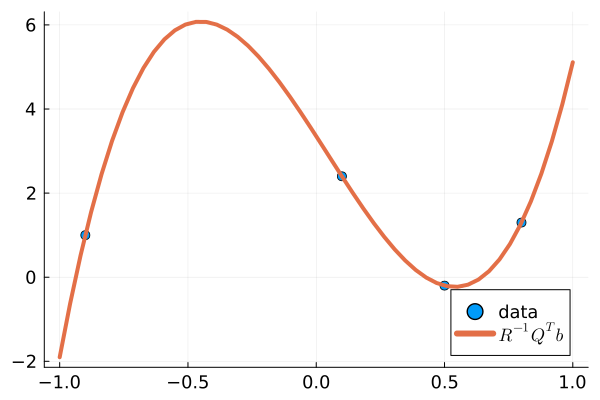

In [4]:
# Let's fit a polynomial to these points
x1 = [-0.9, 0.1, 0.5, 0.8]
y1 = [1, 2.4, -0.2, 1.3]
scatter(x1, y1, label="data")

Q, R = gram_schmidt_naive(vander(x1, 4))
p = R \ (Q' * y1) # Using \ to solve R^-1, easy for upper triangular
plot!(x, vander(x, 4) * p, label="\$R^{-1}Q^Tb\$")

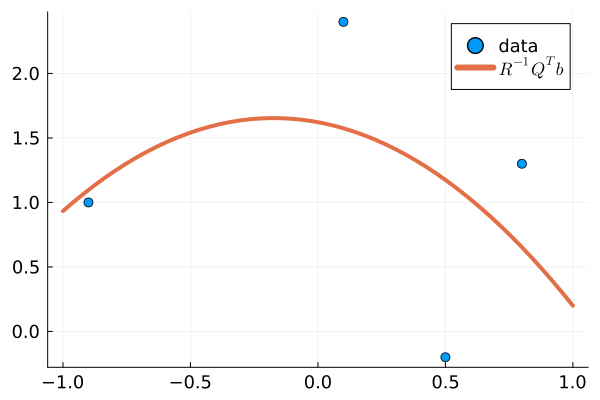

In [5]:
# What about a lower order polynomial?
Q, R = gram_schmidt_naive(vander(x1, 3))
p = R \ (Q' * y1) # Using \ to solve R^-1, easy for upper triangular
scatter(x1, y1, label="data")
plot!(x, vander(x, 3) * p, label="\$R^{-1}Q^Tb\$")

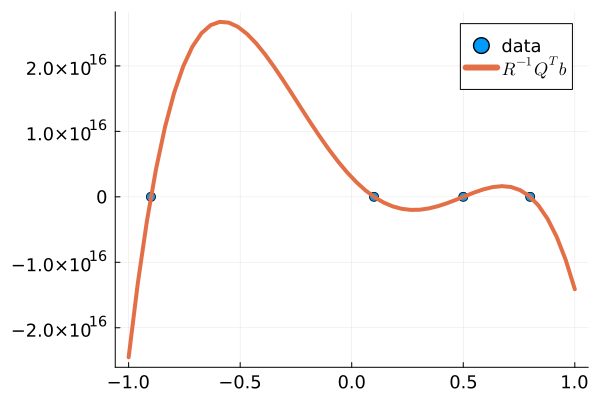

In [6]:
# What about a higher order polynomial?
Q, R = gram_schmidt_naive(vander(x1, 5))
p = R \ (Q' * y1) # Using \ to solve R^-1, easy for upper triangular
scatter(x1, y1, label="data")
plot!(x, vander(x, 5) * p, label="\$R^{-1}Q^Tb\$")

## How accurate is the result?

In [7]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_naive(A)

@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 7.868453407006443e-9
norm(Q * R - A) = 7.6178704465113005e-16


## A variant with more parallelism

$$ q_2 q_2^T \left( q_1 q_1^T v \right) = q_2 \left( q_2^T q_1 \right) q_1^T v = 0 $$

In [8]:
# Let's form Q and R by making each column orthonormal to all previous columns
function gram_schmidt_classical(A)
    m, n = size(A)
    # Same setup as our niave version
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[: ,j]
        R[1:j-1, j] = Q[:, 1:j-1]' * v
        v -= Q[:, 1:j-1] * R[1:j-1, j]
        R[j, j] = norm(v)
        Q[:, j] = v / norm(v)
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [9]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_classical(A)

@show norm(Q * R - A);

norm(Q * R - A) = 8.582718086704977e-16


## Cost of Gram-Schmidt?

* Let's count FLOPs (addition, multiplication, division, ...)

* Inner product $\sum_{i = 1}^m x_i y_i$

* Vector "axpy": $y_i = a x_i + y_i, i \in \left[ 1, 2, \dots, m \right]$

* Look at the inner loop

```julia
for k in 1:j-1
    r = Q[:,k]' * v
    v -= Q[:,k] * r
    R[k,j] = r
end
```

## Counting FLOPs is a bad model

* We load a single entry (8 bytes) and do 2 FLOPs (add + multiply).
Thats an **arithmetic intensity** of 0.25 FLOPs/byte.

* Current hardware can do about 10 FLOPs per byte, so this algorithm will run at about $2\%$ efficientcy.

* Need to focus on memory bandwidth, not FLOPs.

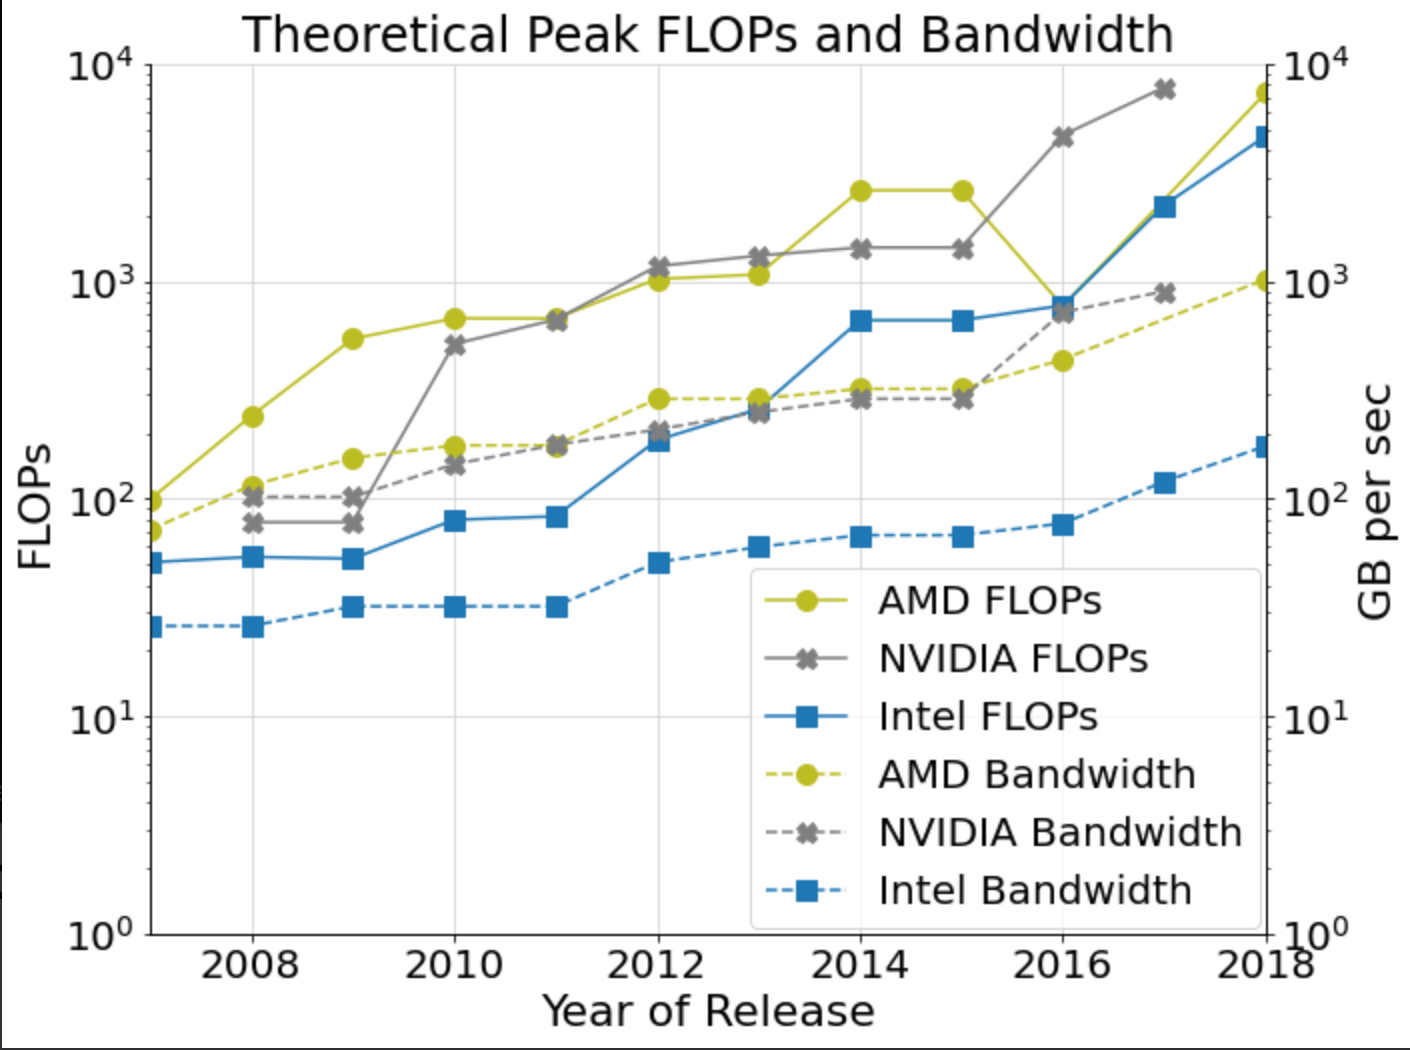

## Dense matrix-matrix multiply

* [BLIS project](https://github.com/flame/blis/)

* [Analytic modeling](https://www.cs.utexas.edu/users/flame/pubs/TOMS-BLIS-Analytical.pdf)

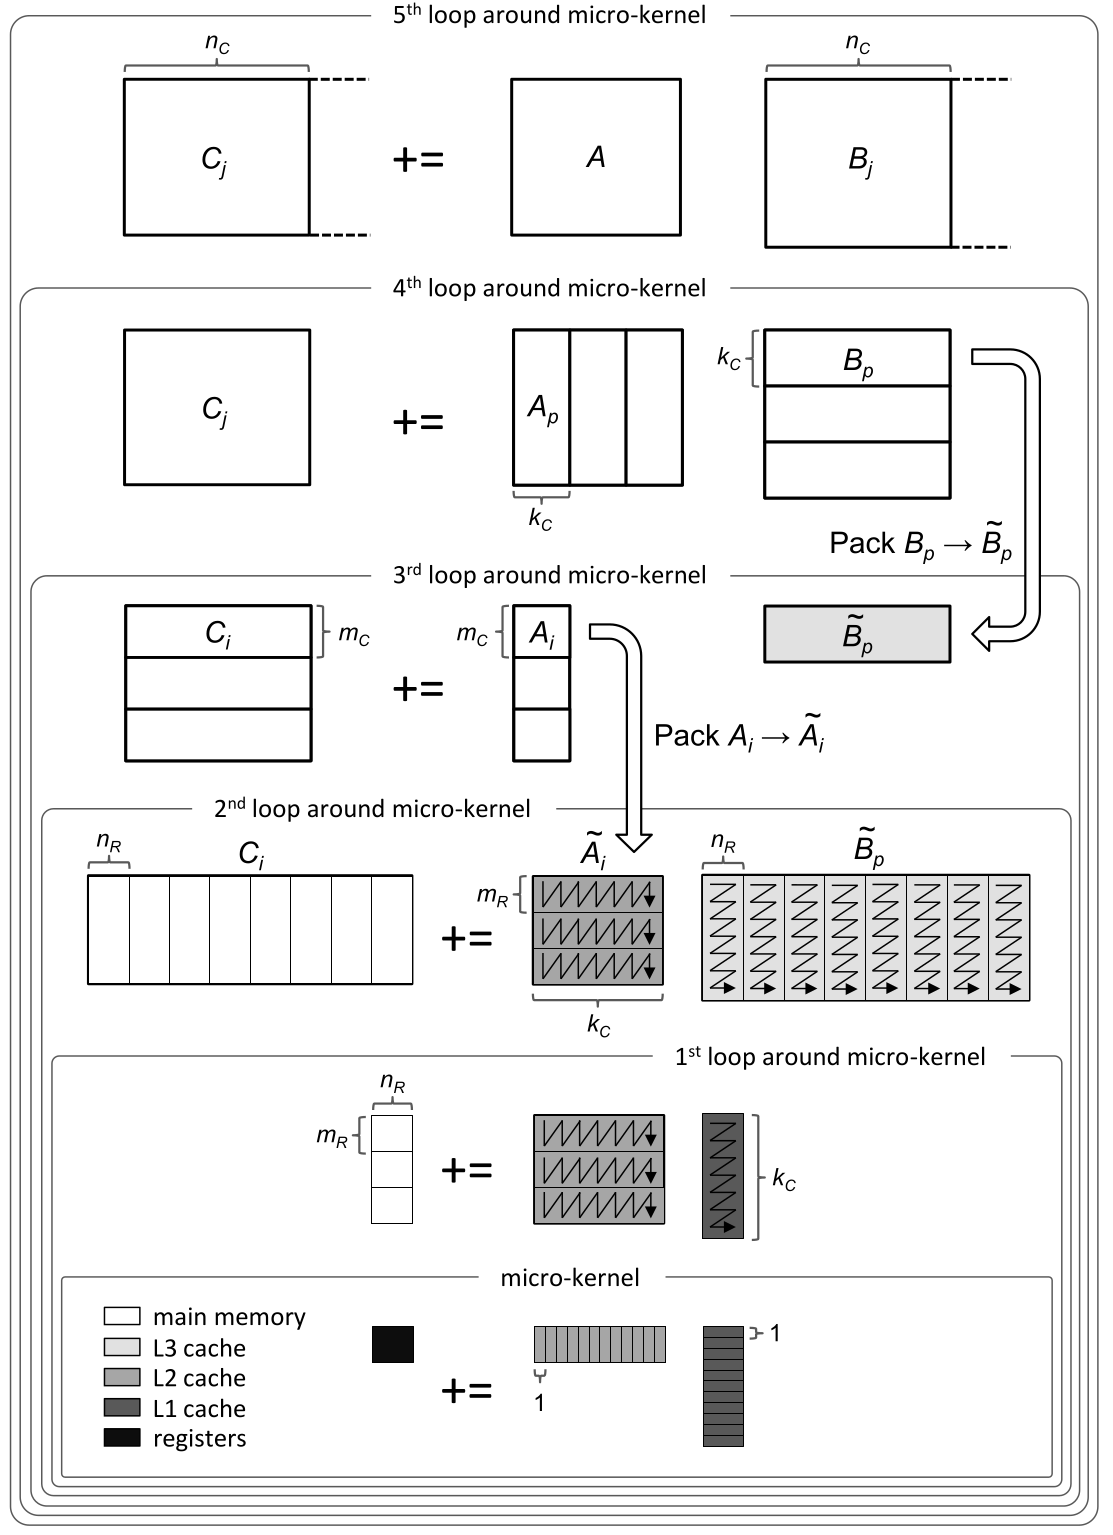